In [1]:
import torch
import torch.nn as nn
import transformers
from transformers import BertModel
from torch.utils.data import Dataset, DataLoader
import numpy as np

import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
SEED = 1234567
MODEL_NAME = 'bert-base-cased'
np.random.seed(SEED)
torch.manual_seed(SEED)

In [3]:
tweets = pd.read_csv("kaggle_clean.csv")

In [4]:
tweets.head()

,Unnamed: 0,textID,text,selected_text,sentiment,hashtag,text_hash_split,text_clean
0,0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,[],"I`d have responded, if I were going",i d have responded if i were going
1,1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,[],Sooo SAD I will miss you here in San Diego!!!,sooo sad i will miss you here in san diego
2,2,088c60f138,my boss is bullying me...,bullying me,negative,[],my boss is bullying me...,my boss is bullying me
3,3,9642c003ef,what interview! leave me alone,leave me alone,negative,[],what interview! leave me alone,what interview leave me alone
4,4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,[],"Sons of ****, why couldn`t they put them on t...",sons of why couldn t they put them on the rele...


In [5]:
tweets.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [6]:
tweets['label'] = np.where(tweets.sentiment == 'negative', 0, np.where(tweets.sentiment == 'neutral', 1, 2))

In [7]:
tweets.sentiment.value_counts()

neutral     11118
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [8]:
tweets.label.value_counts()

1    11118
2     8582
0     7781
Name: label, dtype: int64

In [9]:
len(tweets)

27481

In [10]:
tweets.dropna(inplace=True, subset=['text_clean'])

In [11]:
len(tweets)

27478

In [12]:
tweets['word_counts'] = tweets.text_clean.str.split().map(len)

<Axes: >

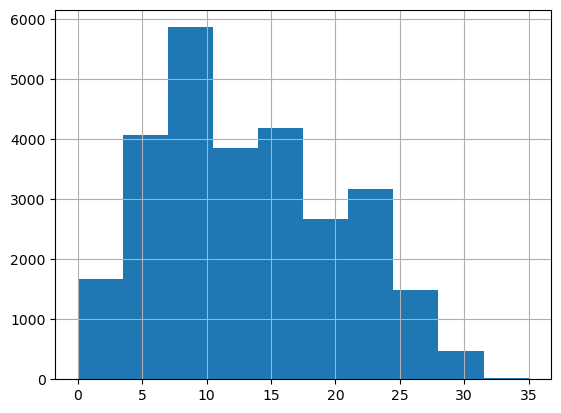

In [13]:
tweets.word_counts.hist()

In [14]:
MAX_LENGTH = 32

In [15]:
train_df , test_df  = train_test_split(tweets, test_size = 0.2, random_state = SEED, shuffle = True)
val_df , test_df  = train_test_split(test_df, test_size = 0.5, random_state = SEED, shuffle = True)

print(train_df.shape , test_df.shape , val_df.shape)

(21982, 10) (2748, 10) (2748, 10)


In [16]:
class Tweets(Dataset):
    def __init__(self, text, target, tokenizer, max_len):
        self.text = text
        self.target = target
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self,idx):
        text = self.text[idx]
        encoding = self.tokenizer.encode_plus(
                          text,
                          add_special_tokens=True,
                          max_length=self.max_len,
                          truncation=True,
                          return_token_type_ids=False,
                          pad_to_max_length=True,
                          return_attention_mask=True,
                          return_tensors='pt')
        
        return {'text' : text,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'target': torch.tensor(self.target[idx], dtype = torch.long)
               }
        

In [17]:
tokenizer = transformers.BertTokenizer.from_pretrained(MODEL_NAME)

training_data = Tweets(text = train_df.text_clean.to_numpy(),
                               target = train_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

validation_data = Tweets(text = val_df.text_clean.to_numpy(),
                               target = val_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

test_data = Tweets(text = test_df.text_clean.to_numpy(),
                               target = test_df.label.to_numpy(),
                               tokenizer = tokenizer,
                               max_len = MAX_LENGTH)

In [18]:
BATCH_SIZE = 64
train_loader = DataLoader(training_data , batch_size = BATCH_SIZE , shuffle = True)
test_loader = DataLoader(test_data , batch_size = BATCH_SIZE , shuffle = False)
val_loader = DataLoader(validation_data , batch_size = BATCH_SIZE , shuffle = False)

In [19]:
class TweetSentimentClassifier(nn.Module):
    def __init__(self, num_classes, dropout=0.3):
        super(TweetSentimentClassifier,self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.dropout = nn.Dropout(p = dropout)
        self.linear = nn.Linear(self.bert.config.hidden_size,num_classes)
        
    def forward(self,input_ids , attention_mask):
        temp = self.bert(input_ids,attention_mask) 
        pooled_output = temp[1]                    
        out = self.dropout(pooled_output)  
        out = self.linear(out)
        return out

In [20]:
NUM_CLASSES = 3

model = TweetSentimentClassifier(NUM_CLASSES)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
learning_rate = 1e-5
EPOCHS = 20
total_steps = len(train_loader) * EPOCHS

loss_fn = torch.nn.CrossEntropyLoss()

optimizer = transformers.AdamW(params = model.parameters(),lr = learning_rate, correct_bias= False)

scheduler = transformers.get_linear_schedule_with_warmup(optimizer = optimizer,
                                                        num_warmup_steps = 0,
                                                        num_training_steps = total_steps)

/Users/davidhackett/opt/anaconda3/envs/capp30255/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [22]:
def evaluate(model, data_loader, n_examples):
    model.eval()  
    correct_pred = 0
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_id']
            attention_masks = batch['attention_mask']
            targets = batch['target']

            predictions = model(input_ids , attention_masks)
            _,pred_classes = torch.max(predictions, dim=1)

            correct_pred += torch.sum(pred_classes==targets)
            
    return correct_pred / n_examples

In [23]:
def train_model(model, data_loader, criterion, optimizer, scheduler, n_examples, train_log_interval):
    
    model.train()
    correct_pred = 0

    for i, batch in enumerate(data_loader):
        input_ids = batch['input_id']
        attention_masks = batch['attention_mask']
        targets = batch['target']

        predictions = model(input_ids , attention_masks)
        loss = criterion(predictions, targets)
        _, pred_classes = torch.max(predictions, dim=1)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # hack to avoid gradient explotion
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        correct_pred += torch.sum(pred_classes==targets)

        if (i + 1) % train_log_interval == 0:
            print(f"At iteration {i + 1} the train loss is {loss:.3f}.")
    
    return correct_predictions / n_examples
   

In [24]:
TRAIN_LOG_INTERVAL = 100
MODEL_PATH = "best_sentiment_classifier.pt"

def run_training_loops(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs):
    train_accs = []
    valid_accs = []
    best_valid_acc = 0
    
    for epoch in range(epochs):
        train_acc = train_model(model, train_loader, criterion, optimizer, scheduler, len(train_df), TRAIN_LOG_INTERVAL)
        valid_acc = evaluate(model, val_loader, len(val_df))
        train_accs.append(train_acc)
        valid_accs.append(val_acc)
        
        print(f"After epoch {i+1} training accuracy is {train_acc}")
        print(f"After epoch {i+1} validation accuracy is {valid_acc}")
        
        if valid_acc > best_valid_acc:
            best_valid_acc = valid_acc
            torch.save(model.state_dict(), MODEL_PATH)
            
            
    return train_accs, valid_accs
        

        
    

In [25]:
training_accuracy, validation_accuracy = run_training_loops(model, train_loader, val_loader, loss_fn, optimizer, scheduler, EPOCHS)

/Users/davidhackett/opt/anaconda3/envs/capp30255/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(

KeyboardInterrupt

